## Workbook of tonal harmony
#### Analysis of the string quartet Op. 59 n.3 mov. 1 (Introduzione} from music21

In [170]:
from pcsPy import *
import pickle, copy
from IPython.display import Image 
sys.path.append('../')
from tonalHarmonyDefs import enharmonicDictionary, shortHands

Here we import the tonal model we are going to use for the analysis. A tonal model is the matrix of all the operators that connect the chords of a chord library as roman numerals.
Typical models are built using combinations of basic chord symbols and possible extension. 

Use tonalHarmonyModel.py to generate or modify models

In [2]:
f = open('../tonal.harmony.minimal','rb')
head = pickle.load(f)
table = pickle.load(f)
f.close()
tab = np.array(table)

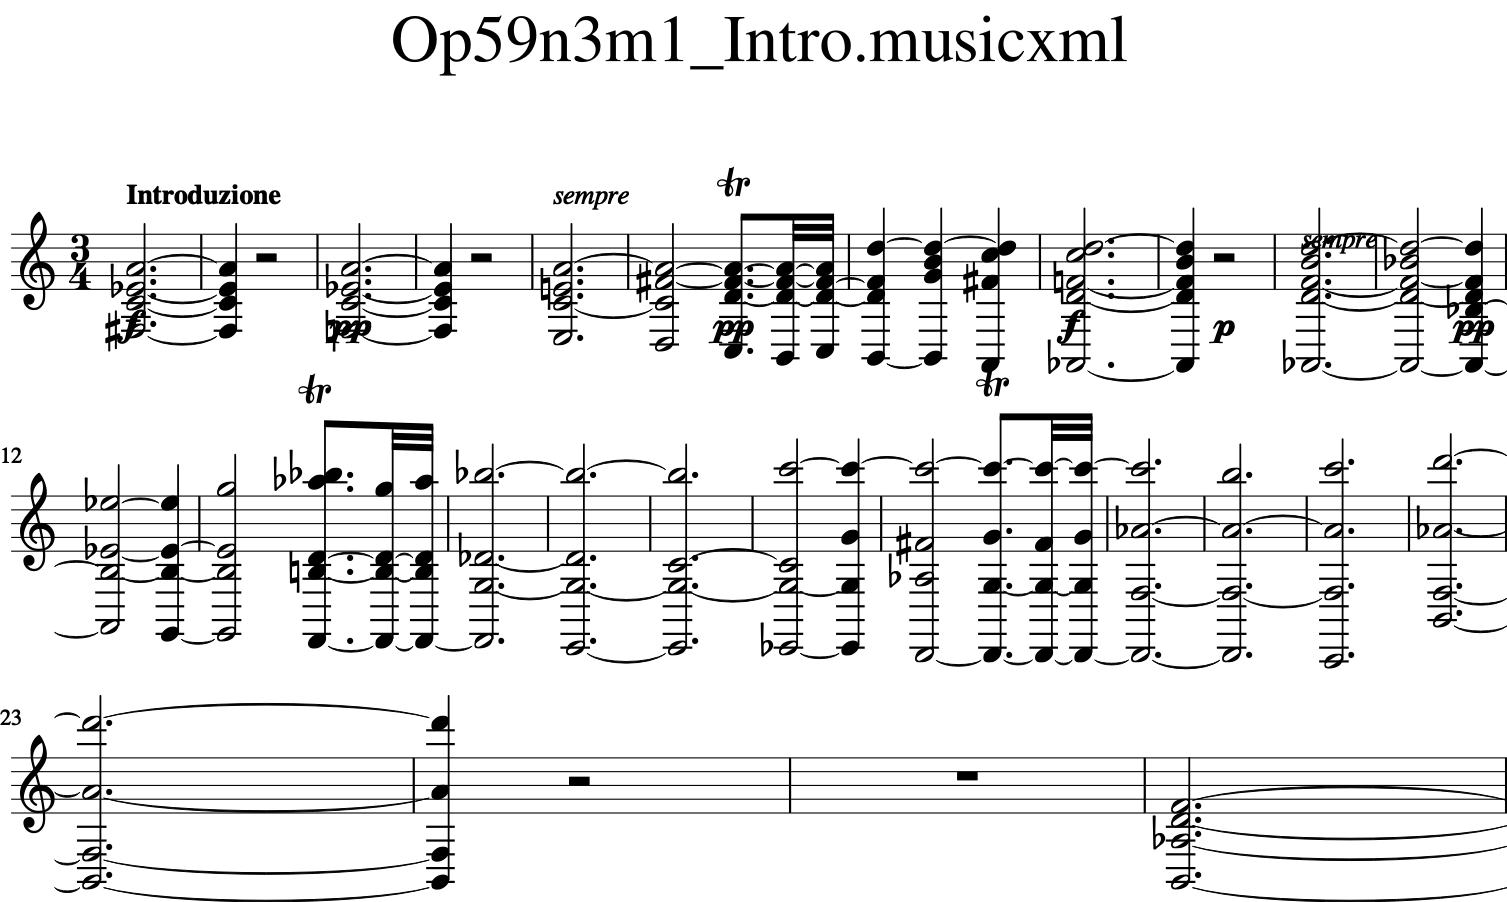

In [139]:
score = 'Op59n3m1_Intro.musicxml'
seq,chords = readScore(score,music21=False,show=True)

In [ ]:
# To write chords and corresponding operators - uses musescore
WRITEscoreOps(seq,w=True)

In [6]:
dnodes,dedges,dcounts,deg,modul,Gx,Gxu = scoreNetwork(seq,ntx=True,general=True)
print('average degree = ',deg,' modularity = ',modul)
# Write to csv for visualization in Gephi or other network drawing software (see figure below)
dnodes.to_csv('nodesOp59n3m1.csv')
dedges.to_csv('edgesOp59n3m1.csv')
# Get modularity scores
part = cm.best_partition(Gxu) #,resolution=0.4)

average degree =  1.2608695652173914  modularity =  0.5608


## ![title](Op59n3m1.png)

In [7]:
dn = np.array(dnodes)
labe = []
modu = []
modul = []
for m in range(len(dn)):
    labe.append(str(dn[m][0]))
    modu.append(part[str(m)])
    modul.append([str(dn[m][0]),Gx.degree()[str(m)],part[str(m)]])
modul = pd.DataFrame(modul,columns=['Label','Degree','Modularity'])
moduldict = dict(zip(labe,modu))

In [8]:
# display the score with modularity classes
mc = []
seqmc = []
for n in range(len(seq)):
    p = PCSet(np.asarray(seq[n]))
    nn = ''.join(m21.chord.Chord(p.normalOrder().tolist()).pitchNames)
    mc.append(nn)
    seqmc.append(moduldict[nn])

In [9]:
l = 0
analyzed = copy.deepcopy(chords)
for c in analyzed.recurse().getElementsByClass('Chord'):
    c.closedPosition(forceOctave=4,inPlace=True)
    c.addLyric(str(l))
    c.addLyric(seqmc[l])
    l += 1
analyzed.show('musicxml')

In [ ]:
modul.to_csv('~/Desktop/modul.csv')

In [34]:
modul[['Label','Degree','Modularity']].query('Modularity == 2').sort_values(by=['Degree'],ascending=False)

,Label,Degree,Modularity
8,CDG,4,2
7,CDFA-,3,2
6,CDF#G,2,2


In [42]:
# Dictionary of modularity classes and relative keys
keydict = {0:'B-', 1:'G', 2:'G', 3:'C', 4:'C', 5:'A'}

In [ ]:
# moduldict['B-CE'] = 2
# moduldict['C#EG'] = 3
# print(moduldict)

In [173]:
# Dictionary of enharmonics for notes in music21 Chords
# Dictionary of shorthand symbols for rn extensions
enharmonicDict = enharmonicDictionary()
figureShorthands = shortHands()

In [142]:
# clean non harmonic grace note at [20]
seq[20] = [2, 5, 8, 11]
seq[21] = [2, 5, 8, 11]
seq[19],seq[20],seq[21],seq[22]

([3, 7, 10], [2, 5, 8, 11], [2, 5, 8, 11], [2, 5, 8, 11])

In [143]:
# Determination of operators
try:
    ntot = seq.shape[0]
except:
    ntot = len(seq)
ops = []
for i in range(ntot):
    if i < ntot-1: 
        ops.append(generalizedOpsName(seq[i],seq[i+1])[1])

In [ ]:
# Score analysis
verbose = False
# First chord
rn = []
ch = np.copy(seq[0])
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
n = m21.chord.Chord(ch.tolist())
chord = ''.join(n.pitchNames)
key = keydict[moduldict[chord]] 
rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
# Full score
nx = ntot-1
i = 0
check = 0
while i < nx:   
    try:
        if i == 110000:
            rn.append(' ')
        elif i == 48000:
            rn.append(' ')
        else:
            idx,idy = np.where(tab == ops[i])
            tmp = []
            for n in range(len(idy)):
                if (rn[i] == str(head[idx[n]])):
                    tmp.append(head[idy[n]])
            if len(tmp) == 1:
                rn.append(tmp[0])
            else:
                chord = ''.join(m21.chord.Chord(PCSet(seq[i]).normalOrder().tolist()).pitchNames)
                key = keydict[moduldict[chord]]
                for n in range(len(tmp)):
                    ch = m21.roman.RomanNumeral(tmp[n],m21.key.Key(key)).pitchClasses
                    if PCSet(ch).normalOrder().tolist() == seq[i+1]:
                        rn.append(str(tmp[n]))
                        break
        i += 1
    except Exception as e:
        if verbose: print(i,'try',type(e),e,chord)
        try:
            if check == i:
                print('check error')
                break
            else:
                print('modulation at or before chord no. ',i)
                check = i
                rn.pop()
                ch = np.copy(PCSet(seq[i-1]).normalOrder().tolist())
                for n in range(1,len(ch)):
                    if ch[n] < ch[n-1]: ch[n] += 12
                ch += 60
                p = []
                for c in ch:
                    p.append(notedict[c])
                n = m21.chord.Chord(p)
                chord = ''.join(n.pitchNames)
                m = m21.chord.Chord(ch.tolist())
                try:
                    key = keydict[moduldict[''.join(m.pitchNames)]] 
                    if i == 17: key = 'E-'
                    rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
                    # 
                    if rn[i-1] == 'V65': rn[i-1] = 'V7'
                    if rn[i-1] == 'V42': rn[i-1] = 'V7[no5]'
                    if rn[i-1] == 'I42': rn[i-1] = 'I7[no5]'
                    if rn[i-1] == 'II65': rn[i-1] = 'II7'
                    if rn[i-1] == 'viio6b5': rn[i-1] = 'viio7'
                    if rn[i-1] == 'ivo5b3': rn[i-1] = 'ivo'
                    if rn[i-1] == 'bI6b5': rn[i-1] = 'VII7'
                    if rn[i-1] == '#vob64b3': rn[i-1] = 'viio7'
                    if verbose: print(i-1,'except',n,rn[i-1],key,'\n')
                    i -= 1
                except Exception as e:
                    print(type(e),e,chord)
                    break
        except Exception as e:
            print(type(e),e) 
            break
nx = i

In [189]:
# Score analysis
verbose = False
# First chord
rn = []
ch = np.copy(seq[0])
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
n = m21.chord.Chord(ch.tolist())
chord = ''.join(n.pitchNames)
key = keydict[moduldict[chord]] 
rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
# Full score
nx = ntot-1
i = 0
check = 0
while i < nx:   
    try:
        if i == 110000:
            rn.append(' ')
        elif i == 48000:
            rn.append(' ')
        else:
            idx,idy = np.where(tab == ops[i])
            tmp = []
            for n in range(len(idy)):
                if (rn[i] == str(head[idx[n]])):
                    tmp.append(head[idy[n]])
            if len(tmp) == 1:
                rn.append(tmp[0])
            else:
                chord = ''.join(m21.chord.Chord(PCSet(seq[i]).normalOrder().tolist()).pitchNames)
                key = keydict[moduldict[chord]]
                for n in range(len(tmp)):
                    ch = m21.roman.RomanNumeral(tmp[n],m21.key.Key(key)).pitchClasses
                    if PCSet(ch).normalOrder().tolist() == seq[i+1]:
                        rn.append(str(tmp[n]))
                        break
        i += 1
    except Exception as e:
        if verbose: print(i,'try',type(e),e,chord)
        try:
            if check == i:
                print('check error')
                break
            else:
                print('modulation at or before chord no. ',i)
                check = i
                rn.pop()
                ch = np.copy(PCSet(seq[i-1]).normalOrder().tolist())
                for n in range(1,len(ch)):
                    if ch[n] < ch[n-1]: ch[n] += 12
                ch += 60
                m = m21.chord.Chord(ch.tolist())
                key = keydict[moduldict[''.join(m.pitchNames)]]
#                 Manual control of modulations
                if i == 17: key = 'E-'
                p = []
                for c in ch:
                    p.append(enharmonicDict[key][c])
                n = m21.chord.Chord(p)
                chord = ''.join(n.pitchNames)                
                try:
                    rnum = m21.roman.romanNumeralFromChord(n,m21.key.Key(key)).romanNumeralAlone
                    fig = m21.roman.postFigureFromChordAndKey(n,m21.key.Key(key))
                    try:
                        fig = figureShorthands[fig]
                    except:
                        pass
                    rn.append(rnum+fig)
                    if verbose: print(i-1,'except',n,rn[i-1],key,'\n')
                    i -= 1
                except Exception as e:
                    print(type(e),e,chord)
                    break
        except Exception as e:
            print(type(e),e) 
            break
nx = i

modulation at or before chord no.  1
modulation at or before chord no.  9
modulation at or before chord no.  14
modulation at or before chord no.  17
modulation at or before chord no.  30
modulation at or before chord no.  34


In [159]:
# print(rn[19])
# print(ops[20])
ch = np.copy(PCSet([11,2,5,8]).normalOrder().tolist())
print(ch.tolist())
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
print(ch)
p = []
for c in ch:
    p.append(notedict[c])
print(p)
n = m21.chord.Chord(p)
print(n.chordTablesAddress)
print(n,n.normalOrder)
print(m21.roman.romanNumeralFromChord(n, m21.key.Key('C')).figure)

[2, 5, 8, 11]
[62 65 68 71]
['D4', 'F4', 'A-4', 'B4']
ChordTableAddress(cardinality=4, forteClass=28, inversion=0, pcOriginal=2)
<music21.chord.Chord D4 F4 A-4 B4> [2, 5, 8, 11]
viio6b5


In [166]:
es = m21.analysis.enharmonics.EnharmonicSimplifier([p for p in n.pitches])
es.bestPitches()

(<music21.pitch.Pitch D4>,
 <music21.pitch.Pitch F4>,
 <music21.pitch.Pitch A-4>,
 <music21.pitch.Pitch B4>)

In [ ]:
# Score analysis
# First chord
rn = []
ch = np.copy(seq[0])
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
n = m21.chord.Chord(ch.tolist())
chord = ''.join(n.pitchNames)
key = keydict[moduldict[chord]] 
rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
# Full score
nx = ntot-1
for i in range(nx):
    try:
        # these are the modulations
        if i == 4:
            rn.append('i')
        elif i == 5:
            rn.append('I')
        elif i == 10:
            rn.append('I')
        elif i == 11:
            rn.append('viio7')
        elif i == 17:
            rn.append('i')
        else:
            idx,idy = np.where(tab == ops[i])
            tmp = []
            for n in range(len(idy)):
                if (rn[i] == str(head[idx[n]])):
                    tmp.append(head[idy[n]])
            if len(tmp) == 1:
                rn.append(tmp[0])
            else:
                chord = ''.join(m21.chord.Chord(PCSet(seq[i]).normalOrder().tolist()).pitchNames)
                key = keydict[moduldict[chord]]
                for n in range(len(tmp)):
                    ch = m21.roman.RomanNumeral(tmp[n],m21.key.Key(key)).pitchClasses
                    if PCSet(ch).normalOrder().tolist() == seq[i+1]:
                        rn.append(str(tmp[n]))
                        break
    except Exception as e:
        print('check at or before chord no. ',i,' for possible modulation')
        print(type(e),e)
        nx = i
        break

In [184]:
# Create dictionary of score analysis
reference = []
for n in range(nx):
    try:
        chord = ''.join(m21.chord.Chord(PCSet(seq[n]).normalOrder().tolist()).pitchNames)
        entry = [PCSet(seq[n]).normalOrder(),chord,rn[n],ops[n],keydict[moduldict[chord]],moduldict[chord]]
        reference.append(entry)
    except:
        pass

In [185]:
# Add last chord
ops.append(' ')
chord = ''.join(m21.chord.Chord(PCSet(seq[nx]).normalOrder().tolist()).pitchNames)
entry = [PCSet(seq[nx]).normalOrder(),chord,rn[nx],ops[nx],keydict[moduldict[chord]]]
reference.append(entry)

In [186]:
# Set dictionary as pandas dataframe
analysis = pd.DataFrame(reference,columns=['pcs','chord','rn','ops','key','modul'])

In [187]:
analysis

,pcs,chord,rn,ops,key,modul
0,"[0, 3, 6, 9]",CE-F#A,viio7,"O(0,0,0,0)",B-,0.0
1,"[0, 3, 6, 9]",CE-F#A,iio7,"O(0,0,-1,0)",B-,0.0
2,"[9, 0, 3, 5]",ACE-F,V7,"O(0,0,0,0)",B-,0.0
3,"[9, 0, 3, 5]",ACE-F,V7,"O(0,0,1,-1)",B-,0.0
4,"[9, 0, 4]",ACE,vii,"O(2,2,0,0)",B-,0.0
5,"[6, 9, 0, 2]",F#ACD,III7,"O(0,0,0,0)",G,1.0
6,"[6, 9, 0, 2]",F#ACD,III7,"O(0,0,-1,0)",G,1.0
7,"[6, 9, 11, 2]",F#ABD,IIIb7,"O(0,0,1,0)",G,1.0
8,"[6, 9, 0, 2]",F#ACD,V7,"O(0,2,-1,0)",G,1.0
9,"[11, 2, 6]",BDF#,iii,"O(0,0,1)",G,1.0


In [129]:
analysis.to_csv('Op59n3m1.csv')

In [152]:
# display the analyzed score
l = 0
analyzed = copy.deepcopy(chords)
for c in analyzed.recurse().getElementsByClass('Chord'):
    c.closedPosition(forceOctave=4,inPlace=True)
    c.addLyric('')
    c.addLyric('')
#     c.addLyric(str(ops[l]))
    c.addLyric(str(rn[l]))
    l += 1
analyzed.show('musicxml')

In [ ]:
seq[49],ops[49],seq[50]

In [ ]:
seq[59],ops[59],seq[60]